### Dataset:
- https://archive.ics.uci.edu/ml/datasets/FMA%3A+A+Dataset+For+Music+Analysis

### Libraries

In [5]:
import os
import numpy as np
import pandas as pd

import ast

import sklearn as skl
from sklearn import preprocessing

from sklearn.svm import SVC

#### Load data

In [3]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [6]:
tracks = load('../data/tracks.csv')
features = load('../data/features.csv')

In [7]:
print("Shape of tracks : ", tracks.shape)
print("Shape of features : ", features.shape)

Shape of tracks :  (106574, 52)
Shape of features :  (106574, 518)


In [8]:
# Load train, val, test set of medium dataset
medium = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

In [9]:
# Create x_train, y_train, x_test, y_test
y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]
X_train = features.loc[medium & train]
X_test = features.loc[medium & test]

In [10]:
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

19922 training examples, 2573 testing examples
518 features, 16 classes


In [11]:
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

In [12]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-2.31296916e-01, -2.33975905e-01,  1.16533023e-01, ...,
        -5.13189614e-01, -8.52162570e-01, -9.01382593e-02],
       [ 9.26064840e-02,  6.82777280e-01, -1.35499410e-01, ...,
        -1.21313133e-01, -7.00878309e-01, -8.42291385e-01],
       [-4.66735180e-01, -2.94790500e-01,  2.05082936e-03, ...,
        -5.13189614e-01,  8.43091404e-01, -2.73593365e-02],
       ...,
       [-4.89343929e-01, -4.94986994e-01, -1.99236596e-01, ...,
        -3.17251373e-01,  1.72207604e-01,  2.64103395e+00],
       [-5.39302574e-01, -5.88055804e-01, -1.77953967e-01, ...,
        -1.21313133e-01,  1.36941072e+00,  1.76063047e+00],
       [-4.79443152e-01, -4.57697694e-01, -8.36406594e-02, ...,
         1.25025455e+00,  1.07589628e-01,  3.55625521e+00]])

#### Training SVM with origin data as paper, not apply RSLDA 

In [13]:
# Support vector classification.
clf = SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 62.88%


### Apply RSLDA

In [15]:
y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]
X_train = features.loc[medium & train]
X_test = features.loc[medium & test]

In [16]:
X_train_temp = np.array(X_train)
X_test_temp = np.array(X_test)

In [17]:
scaler = preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train_temp)

array([[ 4.53785682e+00,  3.45263721e+00,  1.59075970e-03, ...,
        -5.13189614e-01, -3.81407446e-01,  8.52545660e-01],
       [ 1.11898260e+00,  4.72730563e-01,  2.00119191e-02, ...,
        -5.13189614e-01, -5.16431336e-01,  1.16579300e+00],
       [ 2.39404001e-01, -8.60764601e-02, -9.99299225e-02, ...,
        -5.13189614e-01, -3.43980897e-01,  1.93327663e-01],
       ...,
       [ 3.15158641e-01, -6.20587126e-01, -2.66841221e-01, ...,
         4.66501589e-01,  1.27226628e-02, -7.14283610e-01],
       [-3.90204841e-01,  7.89046640e-01, -9.44106825e-02, ...,
        -1.21313133e-01, -4.15344428e-01,  1.23263946e-01],
       [-1.80227023e-01, -2.66659242e-01, -1.52942491e-01, ...,
         7.60408950e-01, -4.17879268e-01, -8.22960438e-01]])

In [18]:
X_train_temp = X_train_temp.T

In [19]:
y_train_temp = np.array(y_train)

In [20]:
# Encode label
le = preprocessing.LabelEncoder()
y_train_temp = le.fit(np.unique(y_train_temp)).transform(y_train_temp)

In [21]:
y_train_temp = y_train_temp.reshape(-1, 1)

In [23]:
print(f"Shape of x_train = {X_train_temp.shape} - Shape of y_train = {y_train_temp.shape}")

Shape of x_train = (518, 19922) - Shape of y_train = (19922, 1)


In [30]:
import sys
sys.path.append("../../")
from RSLDA import RSLDA, sort_power_of_features

In [31]:
P_train, Q_train, E_train, obj_train = RSLDA(X=X_train_temp, label=y_train_temp, dim=512, max_iter=100)

print("Shape of Q = ", Q_train.shape)

RUNNING RSLDA!


100%|██████████| 100/100 [05:04<00:00,  3.04s/it]

Shape of Q =  (518, 512)


#### Select features

In [32]:
# Sort the power of features
sorted_power_train = sort_power_of_features(Q=Q_train)
print("Shape of sorted power of features : ", sorted_power_train.shape)

Shape of sorted power of features :  (518,)


In [33]:
# Select features
NEW_NUM_FEATURES = 500 # Tune for [500, 400, 300, 200, 100]
sorted_power = sorted_power_train[:NEW_NUM_FEATURES]
print("Shape of sorted power : ", sorted_power.shape)

Shape of sorted power :  (500,)


In [34]:
# Create train, test data from new features
X_train_new = np.array(X_train).T[sorted_power].T
X_test_new = np.array(X_test).T[sorted_power].T
y_train_new = np.array(y_train)
y_test_new = np.array(y_test)

In [35]:
print(f"Shape of x_train = {X_train_new.shape} - Shape of y_train = {y_train_new.shape}")
print(f"Shape of x_test = {X_test_new.shape} - Shape of y_test = {y_test_new.shape}")

Shape of x_train = (19922, 500) - Shape of y_train = (19922,)
Shape of x_test = (2573, 500) - Shape of y_test = (2573,)


In [36]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train_new)
scaler.transform(X_test_new)

array([[ 0.0284512 ,  0.21040439,  0.12417407, ..., -0.02682768,
         0.04542178, -0.40757377],
       [-0.06527487, -0.70358955,  0.20390302, ...,  0.47490225,
        -0.19123201, -0.68914526],
       [-0.0338619 ,  1.68559198, -0.58560683, ...,  0.71608383,
         0.08205709,  0.28762714],
       ...,
       [-0.01476993,  0.5011997 ,  0.59870987, ...,  0.57221616,
        -0.55183883,  1.17745318],
       [-0.01323293, -0.50999928, -0.86911587, ..., -1.05634999,
         0.1480799 ,  2.1780856 ],
       [-0.01121049, -0.9968178 ,  0.0630906 , ..., -2.90609597,
        -0.8262343 ,  1.60266463]])

In [37]:
X_train_new, y_train_new = skl.utils.shuffle(X_train_new, y_train_new, random_state=42)

In [38]:
# Support vector classification.
clf = SVC()
clf.fit(X_train_new, y_train_new)
score = clf.score(X_test_new, y_test_new)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 63.00%


#### Results:
- Full (n_fea = 518) : 62.88% 
- n_fea = 500 : 63.00%
- n_fea = 400 : 62.61%
- n_fea = 300 : 62.18%
- n_fea = 200 : 60.05%
- n_fea = 100 : 58.26%

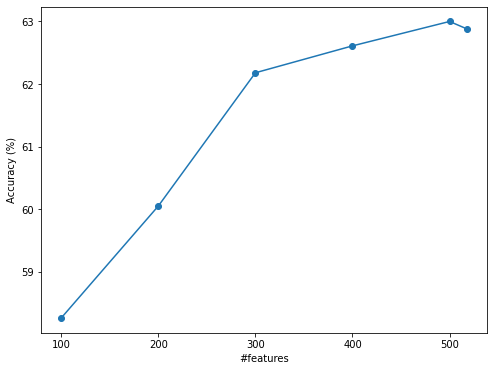

In [48]:
import matplotlib.pyplot as plt
y = [62.88, 63.00, 62.61, 62.18, 60.05, 58.26]
x = [518, 500, 400, 300, 200, 100]
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o')
plt.xlabel("#features")
plt.ylabel("Accuracy (%)")
plt.show()
